In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок
pd.options.display.float_format = '{:,.0f}'.format # формат вывода чисел с плавающей точкой

# Разведывательный анализ данных

## Часть 0. Используемые функции и процедуры

In [2]:
# Функция percentage строит датафрейм, показывающий распределение параметра key_field в заисимости от изменения параметра obj.
# Строки датафрейма: значения или группы значений параметра <b>obj</b>.<br>
# Поля датафрейма: количество значений параметра <b>key_field</b> в абсолютном и процентном виде,
# а также количество строк с отсутствующимb значениями параметра <b>key_field</b>.<br>
# Условие отбора по полю <b>obj</b> - параметр <b>cond</b>.
def percentage (df, key_field, obj, to_display=False):

    # Обработка ошибок
    if (obj not in df.columns) or (key_field not in df.columns):
        print ('Error: there no such column in dataset')
        return None
    
    cond = df[key_field].isna()  
    
    if len(df[cond]) == 0:
        print ('There are no NaN to replace')
        return None
        
    # Для поля 'score' делаем отдельный от других полей индекс для использования в параметре bins в value_counts   
    if obj == 'score': scale = [0,25,50,75,100]
    else: scale = None
        
    # Определяем количество уникальных признаков в key_field и second_obj
    x = len(df[key_field].value_counts())
    
    # Формируем двухуровневый список полей итогового датафрейма
    
    # Формируем первый уровень заголовков
    level_1 = ['with_data'] * (x+1)
    level_1.extend(['%']*x)
    level_1.extend(['without_data'])
    level_1.extend(['to_fill']*x)
    
    # Формируем второй уровень заголовков
    field_list = df[key_field].value_counts().index.tolist()
    level_2 = field_list + ['all'] + field_list + [''] + field_list

    # Формируем индекс итогового датафрейма и создаем датафрейм
    my_index = df[obj].value_counts(bins=scale).index.tolist()
    a = pd.DataFrame(index = my_index, columns = [level_1, level_2])
    a.sort_index (inplace=True)
    
    a['with_data','all'] = df[obj][~cond].value_counts(bins=scale) # Заполняем поле obj, исключая отсутствующие данные в key_field
    a['without_data',''] = df[obj][ cond].value_counts(bins=scale) # Заполняем поле obj из строк, где нет данных по полю key_field
    a['temp'] = 0

    for i in range(x):
        a['with_data',level_2[i]] = df[obj][(~cond) & (df[key_field] == level_2[i])].value_counts(bins=scale)
        a['%'        ,level_2[i]] = a['with_data',level_2[i]] / a['with_data','all'] * 100
        if i<x-1:
            a['to_fill',level_2[i]] = round(a['without_data',''] * a['%',level_2[i]] / 100,0)
            a['temp'] += a['to_fill',level_2[i]]    
        else:
            a['to_fill',level_2[i]] = a['without_data',''] - a['temp']
        a['to_fill',level_2[i]] = a['to_fill',level_2[i]].apply(lambda x: int(x))
    a.drop(['temp'], axis = 1, level = 0, inplace = True)

    if to_display:
        print ('Анализ поля: ',key_field)
        display(a[['with_data']].sum(), a[['without_data']].sum(), a[['to_fill']].sum())
        display (a)
    return a


# Функция out_ranges ищет вылеты из допустимого диапазона для каждого поля датафрейма без учета пропущенных значений.
# Если такие вылеты находятся функция выводит соответствующие строки датафрейма.
# Допустимые значения для каждого поля определены в описании датафрейма, либо взяты из фактических значений
# (например, абсолютное большинство строк в поле school имеют либо значение GP, либо значение MS;
# cоответственно, именно эти значения и будут допустимым интервалом).
def out_ranges():
    flag = False
    for col in stud.columns:
        condition = (~stud[col].isin(threshold[col])) & (~stud[col].isna())
        if len(stud[condition]) != 0:
            print ('\nВылеты по полю ',col,':',sep='')
            display (stud[condition])
            flag = True
    if not flag: print ('Вылетов за устновленные границы диапазонов нет')
    return 0


# Служебная функция make_conditions формирует список условий для группировки значений исследуемого признака
# при изменении значений по полю obj
def make_conditions (df, obj, cond):
    if obj == 'score':
        cond1 = (cond) & (df[obj] <= 25)
        cond2 = (cond) & (df[obj] > 25) & (df[obj] <= 50)
        cond3 = (cond) & (df[obj] > 50) & (df[obj] <= 75)
        cond4 = (cond) & (df[obj] > 75) & (df[obj] <= 100)
        all_cond = [cond1, cond2, cond3, cond4]
        return all_cond
    
    names = df[obj].value_counts().index.tolist()
    all_cond = [((cond) & (df[obj] == c)) for c in names]
    return all_cond


# Функция good_values осуществляет выборку строк с пропущенными значениями исследуемого признака и заполняет пропуски
# на основе распределения имеющихся значений
def good_values (df, key_field, obj, allocation):

    # Формирование условий отбора - получаем список условий
    conditions = make_conditions (df, obj, df[key_field].isna())
    
    # Получаем список уникальных значений исследуемого признка
    buscets = df[key_field].value_counts().index.tolist()
    
    # Задаем стартовые значения
    start = 0
    result= df.iloc[0:0]
    
    # Формируем датасет result как выборку строк исходного датасета на основе распределения allocation
    for bin_count, bin_name in enumerate(buscets):
        selection = df.iloc[0:0]
    
        for cond_count, cond in enumerate(conditions):
            stop  = int(allocation.iloc[cond_count]['to_fill',bin_name]) + start
            selection = pd.concat([selection, stud[cond].iloc[start:stop]])
        
        selection[key_field].fillna(bin_name, inplace = True)

        start += int(allocation.iloc[cond_count]['to_fill',bin_name])
        result = pd.concat([result,selection])
    return result


# Функция fill_values добавляет в исходный датасет заполненные пропуски и удаляет строки с пропусками 
def fill_values (df, key_field, obj='score', stat=0):

    s = percentage (df, key_field, obj, to_display=stat)
    if s is None:
        return df
    
    r = good_values(df, key_field, obj, s)
    df = pd.concat([df,r])
    df = df[~df[key_field].isna()]
    return df

## Часть 1. Импорт и первый взгляд на данные

In [3]:
# Открываем файл, смотрим описание полей датасета
stud = pd.read_csv('stud_math.csv')
stud.info()
display(stud.describe())
nan_values = stud[stud.columns].apply(lambda x: x.isna().sum())
display (nan_values)
print ('Всего отсутствуюет ',nan_values.sum(), ' значений.')
stud.sample(7)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,395,392,371,367,388,373,388,368,384,387,380,383,389
mean,17,3,3,1,2,0,-6,4,3,3,4,7,52
std,1,1,2,1,1,1,3,1,1,1,1,23,23
min,15,0,0,1,1,0,-12,-1,1,1,1,0,0
25%,16,2,2,1,1,0,-6,4,3,2,3,0,40
50%,17,3,2,1,2,0,-6,4,3,3,4,4,55
75%,18,4,3,2,2,0,-3,5,4,4,5,8,70
max,22,4,40,4,4,3,-3,5,5,5,5,385,100


school                  0
sex                     0
age                     0
address                17
famsize                27
Pstatus                45
Medu                    3
Fedu                   24
Mjob                   19
Fjob                   36
reason                 17
guardian               31
traveltime             28
studytime               7
failures               22
schoolsup               9
famsup                 39
paid                   40
activities             14
nursery                16
studytime, granular     7
higher                 20
internet               34
romantic               31
famrel                 27
freetime               11
goout                   8
health                 15
absences               12
score                   6
dtype: int64

Всего отсутствуюет  565  значений.


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
186,GP,M,16,U,GT3,NaN,1,2,services,services,NaN,mother,1,1,0,no,yes,yes,yes,yes,-3,yes,yes,yes,3,3,3,3,2,55
83,GP,M,15,U,LE3,T,2,2,services,services,home,mother,2,2,0,no,no,yes,yes,yes,-6,yes,yes,no,5,3,3,4,4,75
205,GP,F,17,U,GT3,T,3,4,at_home,services,home,mother,1,3,1,no,yes,yes,no,yes,-9,yes,yes,yes,4,4,3,5,28,45
306,GP,M,20,U,GT3,A,3,2,services,other,course,other,1,1,0,no,no,no,yes,yes,-3,yes,no,no,5,5,3,5,0,90
352,MS,M,18,U,LE3,T,1,3,at_home,services,course,mother,1,1,1,no,no,no,no,yes,-3,no,yes,yes,4,3,3,3,nan,40
97,GP,F,16,U,GT3,T,2,1,other,other,course,mother,1,2,0,no,yes,yes,no,yes,-6,yes,no,yes,4,3,5,5,2,50
95,GP,F,15,R,GT3,T,1,1,at_home,other,home,mother,2,4,1,yes,yes,yes,yes,yes,-12,yes,yes,no,3,1,2,1,2,50


### Выводы по первому взгляду на данные:
1. Датасет небольшой: 395 строк.
2. Относительно большой объем отсутствующих данных: по некоторым полям (pstatus, paid) свыше 10%.
3. Датасет содержит 14 полей цифрового типа. Обратим на них повышенное внимание при обработке, будем смотреть распределение и выбросы.
3. Поле 'studytime, granular' не содержится в описании датасета - удаляем.
4. Ключевое поле (score) сожержит 6 пропусков - заполнять их бессмысленно т.к. это поле - итоговое для работы модели. Заполнение пропусков по средней, либо по наиболее частому значению может привкести к искажению результатов анализа. Удаляем. 
5. Первые три поля (school, sex, age) не содержат ошибок - постараемся использовать для заполнения пропусков в других полях.
6. Поле score будем далее использовать как важный классификатор при заполнении отсутствующих данных и модель для контроля количество записей (строк) в датасете

In [4]:
# Удаляем 'studytime, granular'
stud.drop(['studytime, granular'], axis=1, inplace=True)

### Проверим данные на выбросы за рамки здравого смысла
Создадим справочник допустимых значений по каждому из полей датафрейма на основе описания 

In [5]:
threshold = {
    'school': ['GP', 'MS'],
    'sex': ['F', 'M'],
    'age': range(15,23),
    'address': ['R', 'U'],
    'famsize': ['GT3', 'LE3'],
    'Pstatus': ['T', 'A'],
    'Medu': range(0,5),
    'Fedu': range(0,5),
    'Mjob': ['teacher', 'health', 'services', 'at_home', 'other'],
    'Fjob': ['teacher', 'health', 'services', 'at_home', 'other'],
    'reason':['home', 'reputation', 'course', 'other'],
    'guardian': ['mother', 'father', 'other'],
    'traveltime': range(1,5),
    'studytime': range(1,5),
    'failures': range(0,4),
    'schoolsup': ['yes','no'],
    'famsup': ['yes','no'],
    'paid': ['yes','no'],
    'activities': ['yes','no'],
    'nursery': ['yes','no'],
    'higher': ['yes','no'],
    'internet': ['yes','no'],
    'romantic': ['yes','no'],
    'famrel': range(1,6),
    'freetime': range(1,6),
    'goout': range(1,6),
    'health': range(1,6),
    'absences': range (0,191),
# принимаем продолжительность учебногогода в 38-39 недель; пропусков не может быть больше
# https://www.estudy.ru/important-to-know/articles/view/42-shkolnyi-god-uchebnyi-den-v-shkole-v-velikobritanii.htm
    'score': range(0,101)}

Проверим датафрейм на выбросы за рамки установленных шкал (пока без учета незаполненных значений)

In [6]:
out_ranges()


Вылеты по полю Fedu:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,U,GT3,NaN,2,40,services,other,reputation,father,3,3,0,no,yes,no,yes,yes,yes,yes,no,5,2,2,4,4,60



Вылеты по полю famrel:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,GP,F,16,U,GT3,NaN,2,2,services,services,home,mother,1,1,2,no,yes,yes,no,no,yes,yes,no,-1,2,2,5,14,40



Вылеты по полю absences:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
222,GP,F,16,U,GT3,T,2,3,services,teacher,other,mother,1,2,0,yes,NaN,no,no,yes,yes,yes,no,2,3,1,3,385,85
390,MS,M,20,U,LE3,A,2,2,services,services,course,NaN,1,2,2,no,yes,yes,no,yes,yes,no,no,5,5,4,4,212,45


0

1. Вылет по полю fedu: 40. Допустимый диапазон: от 0 до 4. Очевидно, это опечатка, необходимо заменить на 4. <br>
2. Вылет по полю famrel: -1. Допустимый диапазон: от 1 до 5. Возможно, опечатка; меняем на 1. <br>
3. Два вылета по полю absences: 385 и 212. В качестве допустимого диапазона принят интервал от 0 до 190: максимальное количество учебных дней исходя из 38 учебных недель. Удаляем эти значения, оставляя пропуски (NaN).

In [7]:
stud['Fedu'] = np.where(stud['Fedu'] == 40, 4, stud['Fedu'])
stud['famrel'] = np.where(stud['famrel'] == -1, 1, stud['famrel'])
stud['absences'] = np.where(stud['absences'] == 385, np.nan, stud['absences'])
stud['absences'] = np.where(stud['absences'] == 212, np.nan, stud['absences'])

In [8]:
# Проверяем, что получилось:
out_ranges ()

Вылетов за устновленные границы диапазонов нет


0

## Часть 2. Заполнение пропущенных данных

Большинство полей кроме трех исключений заполним на основании распределения имеющихся данных по этим полям (без пропусков) по 4-м группам итоговых баллов: 0-25, 26-50, 51-75, 76-100.
### Исключнения:
1. Пропуски по полю 'score' заполнять не будем, так как это итоговое поле для будущей модели. 
2. Здравый смысл подсказывает, что поле 'address' может зависить от поля 'school'. //Проверить через корр. анализ// Поэтому, пропуски в поле 'address' заполним на основании распределения по полю 'school'.
2. Поле 'absences' заполним по медиане выборки, состоящей из 80% наиболее частовстречающихся значений

### Исключение 1. Обработка поля score

In [9]:
# Ключевое поле - score - содержит 389 цифровых значений из 395. Смотрим на 6 отсавшихся строк: 
stud[stud['score'].isna()]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
201,GP,F,16,U,GT3,T,2,3,other,other,reputation,mother,1,2,0,yes,yes,NaN,yes,yes,yes,no,no,4,nan,3,4,6,nan
244,GP,F,18,U,GT3,T,2,1,other,other,course,other,2,3,0,no,yes,yes,no,no,yes,yes,yes,4,4,4,3,0,nan
270,GP,F,19,NaN,GT3,T,3,3,other,services,home,other,1,2,2,no,yes,yes,yes,yes,yes,yes,no,4,3,5,5,nan,nan
283,GP,F,18,U,GT3,T,1,1,other,other,home,mother,2,2,0,yes,NaN,no,yes,yes,yes,yes,no,5,nan,4,4,4,nan
312,GP,M,19,U,GT3,T,1,2,other,services,course,other,1,2,1,no,no,no,no,no,yes,yes,no,4,5,nan,4,3,nan
350,MS,M,19,NaN,GT3,T,1,1,other,services,home,other,3,2,3,no,no,no,no,NaN,yes,yes,no,5,4,4,2,8,nan


In [10]:
# Удаляем строки с NaN в поле score
field = 'score'
condition = stud[field].isna()
stud = stud[~condition]

In [11]:
# Проверяем, что получилось
print('Пропусков в поле ', field, ': %d. Записей в датасете: %d' % (stud[field].isna().sum(), len(stud)))

Пропусков в поле  score : 0. Записей в датасете: 389


(80.0, 100.0]    0
(-0.101, 20.0]   0
(20.0, 40.0]     0
(60.0, 80.0]     0
(40.0, 60.0]     0
Name: score, dtype: float64

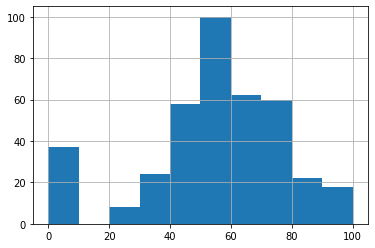

In [12]:
# Посмотрим на распределение значений в поле 'score'
stud['score'].hist()
stud['score'].value_counts(bins=5, normalize=True, ascending=True)

Обращаем внимание на нормальное распределение признака за исключением нескольких нулевых значений. Наибольшее количество значений укладывается в диапазон от 40 до 80.

### Исключение 2.  Обработка поля address

In [13]:
# Посмотрим на рспределение адресов в заисимости от школы 
field = 'address'
s = percentage (stud, field, 'school', to_display=True)
s

Анализ поля:  address


with_data  U      291
           R       83
           all    374
dtype: int64

without_data      15
dtype: int64

to_fill  U    11
         R     4
dtype: int64

with_data           %    without_data to_fill   
           U   R  all  U  R                    U  R
GP       273  60  333 82 18           11       9  2
MS        18  23   41 44 56            4       2  2

with_data           %    without_data to_fill   
           U   R  all  U  R                    U  R
GP       273  60  333 82 18           11       9  2
MS        18  23   41 44 56            4       2  2

Основная часть студентов школы GP (82%) живет в городе (U), тогда как в школе MS
адреса студентов распределены примерно поровну.

In [14]:
# Поле адрес заполняем на основе изменений по полю school 
field = 'address'
stud = fill_values (stud, field, obj='school', stat=0)

In [15]:
condition = stud[field].isna()
stud = stud[~condition]

In [16]:
# Проверяем, что получилось
print('Пропусков в поле ', field, ': %d. Записей в датасете: %d' % (stud[field].isna().sum(), len(stud)))

Пропусков в поле  address : 0. Записей в датасете: 389


### Исключение 3.  Обработка поля absences

In [17]:
field = 'absences'
print('Пропусков в поле ', field, ': %d. Записей в датасете: %d' % (stud[field].isna().sum(), len(stud)))

Пропусков в поле  absences : 13. Записей в датасете: 389


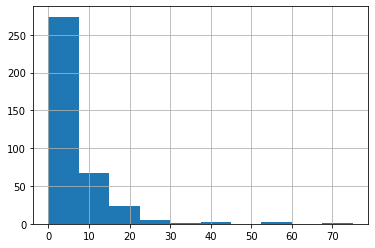

In [18]:
stud[field].hist()

Видно, что большинство пропусков не превышает 20

In [19]:
low_absences = stud[((stud[field].isna()) | (stud[field] <= 20))]
stud['absences'].fillna(low_absences['absences'].median(), inplace=True)
stud['absences'].isna().sum()

0

### Обработка всех прочих полей

In [20]:
# Вызываем процедуру заполнения пропусков для всех полей, кроме тех, где пропусков уже нет 
for col in stud.columns[4:27]:
    stud = fill_values (stud, col, stat=1)

Анализ поля:  famsize


with_data  GT3    255
           LE3    107
           all    362
dtype: int64

without_data      27
dtype: int64

to_fill  GT3    19
         LE3     8
dtype: int64

with_data            %     without_data to_fill    
                     GT3 LE3  all GT3 LE3                  GT3 LE3
(-0.001, 25.0]        33   8   41  80  20            4       3   1
(25.0, 50.0]          85  40  125  68  32           13       9   4
(50.0, 75.0]         114  46  160  71  29            6       4   2
(75.0, 100.0]         23  13   36  64  36            4       3   1

Анализ поля:  Pstatus


with_data  T      309
           A       35
           all    344
dtype: int64

without_data      45
dtype: int64

to_fill  T    41
         A     4
dtype: int64

with_data           %    without_data to_fill   
                       T   A  all  T  A                    T  A
(-0.001, 25.0]        39   2   41 95  5            4       4  0
(25.0, 50.0]         112  12  124 90 10           14      13  1
(50.0, 75.0]         128  16  144 89 11           22      20  2
(75.0, 100.0]         30   5   35 86 14            5       4  1

Анализ поля:  Medu


with_data  4.0    131
           2.0     99
           3.0     95
           1.0     57
           0.0      3
           all    385
dtype: int64

without_data      4
dtype: int64

to_fill  4    1
         2    1
         3    1
         1    1
         0    0
dtype: int64

with_data                        %                  \
                     4.0 2.0 3.0 1.0 0.0  all 4.0 2.0 3.0 1.0 0.0   
(-0.001, 25.0]         9  12  12  11   0   44  20  27  27  25   0   
(25.0, 50.0]          38  35  35  26   1  135  28  26  26  19   1   
(50.0, 75.0]          62  47  37  18   2  166  37  28  22  11   1   
(75.0, 100.0]         22   5  11   2   0   40  55  12  28   5   0   

               without_data to_fill                  
                                4.0 2.0 3.0 1.0 0.0  
(-0.001, 25.0]            1       0   0   0   0   1  
(25.0, 50.0]              3       1   1   1   1  -1  
(50.0, 75.0]              0       0   0   0   0   0  
(75.0, 100.0]             0       0   0   0   0   0

Анализ поля:  Fedu


with_data  2.0    103
           3.0     93
           4.0     91
           1.0     80
           0.0      2
           all    369
dtype: int64

without_data      23
dtype: int64

to_fill  2    7
         3    5
         4    6
         1    4
         0    1
dtype: int64

with_data                        %                  \
                     2.0 3.0 4.0 1.0 0.0  all 2.0 3.0 4.0 1.0 0.0   
(-0.001, 25.0]        14   7  10  11   0   42  33  17  24  26   0   
(25.0, 50.0]          32  39  20  42   1  134  24  29  15  31   1   
(50.0, 75.0]          49  36  49  22   0  156  31  23  31  14   0   
(75.0, 100.0]          8  11  12   5   1   37  22  30  32  14   3   

               without_data to_fill                  
                                2.0 3.0 4.0 1.0 0.0  
(-0.001, 25.0]            3       1   0   1   1   0  
(25.0, 50.0]              7       2   2   1   2   0  
(50.0, 75.0]             10       3   2   3   1   1  
(75.0, 100.0]             3       1   1   1   0   0

Анализ поля:  Mjob


with_data  other       133
           services     90
           teacher      60
           at_home      58
           health       32
           all         373
dtype: int64

without_data      18
dtype: int64

to_fill  other       6
         services    5
         teacher     3
         at_home     2
         health      2
dtype: int64

with_data                                          %           \
                   other services teacher at_home health  all other services   
(-0.001, 25.0]        17        9       4      10      2   42    40       21   
(25.0, 50.0]          49       25      25      28      8  135    36       19   
(50.0, 75.0]          61       42      22      18     17  160    38       26   
(75.0, 100.0]          6       14       9       2      5   36    17       39   

                                      without_data to_fill                   \
               teacher at_home health                other services teacher   
(-0.001, 25.0]      10      24      5            2       1        0       0   
(25.0, 50.0]        19      21      6            6       2        1       1   
(50.0, 75.0]        14      11     11            6       2        2       1   
(75.0, 100.0]       25       6     14            4       1        2       1   

                               
               at_home health  
(-0.001, 25.0]       0      1  
(25.0, 50.0]         1      1  
(50.0, 75.0]         1      0  
(75.0, 100.0]        0      0

Анализ поля:  Fjob


with_data  other       194
           services     99
           teacher      28
           health       17
           at_home      15
           all         353
dtype: int64

without_data      37
dtype: int64

to_fill  other       19
         services    10
         teacher      5
         health       2
         at_home      1
dtype: int64

with_data                                          %           \
                   other services teacher health at_home  all other services   
(-0.001, 25.0]        19       12       3      0       2   36    53       33   
(25.0, 50.0]          77       34       6      7       5  129    60       26   
(50.0, 75.0]          85       46      10      9       6  156    54       29   
(75.0, 100.0]         13        7       9      1       2   32    41       22   

                                      without_data to_fill                   \
               teacher health at_home                other services teacher   
(-0.001, 25.0]       8      0       6            7       4        2       1   
(25.0, 50.0]         5      5       4           12       7        3       1   
(50.0, 75.0]         6      6       4           10       5        3       1   
(75.0, 100.0]       28      3       6            8       3        2       2   

                               
               health at_home  
(-0.001, 25.0]      0       0  
(25.0, 50.0]        1       0  
(50.0, 75.0]        1       0  
(75.0, 100.0]       0       1

Анализ поля:  reason


with_data  course        138
           home          109
           reputation     98
           other          29
           all           374
dtype: int64

without_data      16
dtype: int64

to_fill  course        5
         home          4
         reputation    4
         other         3
dtype: int64

with_data                                 %                  \
                  course home reputation other  all course home reputation   
(-0.001, 25.0]        19   12          7     2   40     48   30         18   
(25.0, 50.0]          51   41         34    11  137     37   30         25   
(50.0, 75.0]          54   46         46    12  158     34   29         29   
(75.0, 100.0]         14   10         11     4   39     36   26         28   

                     without_data to_fill                        
               other               course home reputation other  
(-0.001, 25.0]     5            3       1    1          1     0  
(25.0, 50.0]       8            4       1    1          1     1  
(50.0, 75.0]       8            8       3    2          2     1  
(75.0, 100.0]     10            1       0    0          0     1

Анализ поля:  guardian


with_data  mother    250
           father     88
           other      23
           all       361
dtype: int64

without_data      29
dtype: int64

to_fill  mother    20
         father     7
         other      2
dtype: int64

with_data                        %              without_data  \
                  mother father other  all mother father other                
(-0.001, 25.0]        29      9     3   41     71     22     7            2   
(25.0, 50.0]          86     32    11  129     67     25     9           12   
(50.0, 75.0]         107     37     7  151     71     25     5           15   
(75.0, 100.0]         28     10     2   40     70     25     5            0   

               to_fill               
                mother father other  
(-0.001, 25.0]       1      0     1  
(25.0, 50.0]         8      3     1  
(50.0, 75.0]        11      4     0  
(75.0, 100.0]        0      0     0

Анализ поля:  traveltime


with_data  1.0    242
           2.0     90
           3.0     22
           4.0     11
           all    365
dtype: int64

without_data      25
dtype: int64

to_fill  1    16
         2     7
         3     1
         4     1
dtype: int64

with_data                    %             without_data  \
                     1.0 2.0 3.0 4.0  all 1.0 2.0 3.0 4.0                
(-0.001, 25.0]        24  11   4   0   39  62  28  10   0            4   
(25.0, 50.0]          83  36   8   8  135  61  27   6   6            6   
(50.0, 75.0]         108  34   9   3  154  70  22   6   2           12   
(75.0, 100.0]         27   9   1   0   37  73  24   3   0            3   

               to_fill              
                   1.0 2.0 3.0 4.0  
(-0.001, 25.0]       2   1   0   1  
(25.0, 50.0]         4   2   0   0  
(50.0, 75.0]         8   3   1   0  
(75.0, 100.0]        2   1   0   0

Анализ поля:  studytime


with_data  2.0    200
           1.0     99
           3.0     57
           4.0     29
           all    385
dtype: int64

without_data      5
dtype: int64

to_fill  2    3
         1    1
         3    0
         4    1
dtype: int64

with_data                    %             without_data  \
                     2.0 1.0 3.0 4.0  all 2.0 1.0 3.0 4.0                
(-0.001, 25.0]        20  14   5   4   43  47  33  12   9            0   
(25.0, 50.0]          82  34  18   6  140  59  24  13   4            1   
(50.0, 75.0]          83  42  25  14  164  51  26  15   9            2   
(75.0, 100.0]         15   9   9   5   38  39  24  24  13            2   

               to_fill              
                   2.0 1.0 3.0 4.0  
(-0.001, 25.0]       0   0   0   0  
(25.0, 50.0]         1   0   0   0  
(50.0, 75.0]         1   1   0   0  
(75.0, 100.0]        1   0   0   1

Анализ поля:  failures


with_data  0.0    297
           1.0     46
           3.0     15
           2.0     12
           all    370
dtype: int64

without_data      20
dtype: int64

to_fill  0    17
         1     3
         3     0
         2     0
dtype: int64

with_data                    %             without_data  \
                     0.0 1.0 3.0 2.0  all 0.0 1.0 3.0 2.0                
(-0.001, 25.0]        21  11   5   4   41  51  27  12  10            2   
(25.0, 50.0]          97  23  10   6  136  71  17   7   4            5   
(50.0, 75.0]         144  11   0   2  157  92   7   0   1            9   
(75.0, 100.0]         35   1   0   0   36  97   3   0   0            4   

               to_fill              
                   0.0 1.0 3.0 2.0  
(-0.001, 25.0]       1   1   0   0  
(25.0, 50.0]         4   1   0   0  
(50.0, 75.0]         8   1   0   0  
(75.0, 100.0]        4   0   0   0

Анализ поля:  schoolsup


with_data  no     326
           yes     55
           all    381
dtype: int64

without_data      8
dtype: int64

to_fill  no     7
         yes    1
dtype: int64

with_data           %     without_data to_fill    
                      no yes  all no yes                   no yes
(-0.001, 25.0]        36   5   41 88  12            1       1   0
(25.0, 50.0]         106  32  138 77  23            3       2   1
(50.0, 75.0]         145  17  162 90  10            4       4   0
(75.0, 100.0]         39   1   40 98   2            0       0   0

Анализ поля:  famsup


with_data  yes    224
           no     127
           all    351
dtype: int64

without_data      38
dtype: int64

to_fill  yes    25
         no     13
dtype: int64

with_data            %    without_data to_fill   
                     yes  no  all yes no                  yes no
(-0.001, 25.0]        26  14   40  65 35            2       1  1
(25.0, 50.0]          84  44  128  66 34           13       9  4
(50.0, 75.0]          91  56  147  62 38           19      12  7
(75.0, 100.0]         23  13   36  64 36            4       3  1

Анализ поля:  paid


with_data  no     198
           yes    152
           all    350
dtype: int64

without_data      38
dtype: int64

to_fill  no     22
         yes    16
dtype: int64

with_data           %     without_data to_fill    
                      no yes  all no yes                   no yes
(-0.001, 25.0]        28   9   37 76  24            4       3   1
(25.0, 50.0]          67  58  125 54  46           16       9   7
(50.0, 75.0]          78  73  151 52  48           15       8   7
(75.0, 100.0]         25  12   37 68  32            3       2   1

Анализ поля:  activities


with_data  yes    190
           no     184
           all    374
dtype: int64

without_data      14
dtype: int64

to_fill  yes    7
         no     7
dtype: int64

with_data            %    without_data to_fill   
                     yes  no  all yes no                  yes no
(-0.001, 25.0]        18  19   37  49 51            4       2  2
(25.0, 50.0]          65  71  136  48 52            5       2  3
(50.0, 75.0]          86  75  161  53 47            5       3  2
(75.0, 100.0]         21  19   40  52 48            0       0  0

Анализ поля:  nursery


with_data  yes    303
           no      72
           all    375
dtype: int64

without_data      13
dtype: int64

to_fill  yes    11
         no      2
dtype: int64

with_data            %    without_data to_fill   
                     yes  no  all yes no                  yes no
(-0.001, 25.0]        31   8   39  79 21            2       2  0
(25.0, 50.0]         112  25  137  82 18            4       3  1
(50.0, 75.0]         127  35  162  78 22            4       3  1
(75.0, 100.0]         33   4   37  89 11            3       3  0

Анализ поля:  higher


with_data  yes    347
           no      18
           all    365
dtype: int64

without_data      23
dtype: int64

to_fill  yes    22
         no      1
dtype: int64

with_data           %    without_data to_fill   
                     yes no  all yes no                  yes no
(-0.001, 25.0]        36  4   40  90 10            1       1  0
(25.0, 50.0]         120  9  129  93  7           12      11  1
(50.0, 75.0]         152  5  157  97  3            9       9  0
(75.0, 100.0]         39  0   39 100  0            1       1  0

Анализ поля:  internet


with_data  yes    297
           no      59
           all    356
dtype: int64

without_data      32
dtype: int64

to_fill  yes    26
         no      6
dtype: int64

with_data            %    without_data to_fill   
                     yes  no  all yes no                  yes no
(-0.001, 25.0]        31   6   37  84 16            4       3  1
(25.0, 50.0]         109  23  132  83 17            9       7  2
(50.0, 75.0]         123  27  150  82 18           16      13  3
(75.0, 100.0]         34   3   37  92  8            3       3  0

Анализ поля:  romantic


with_data  no     245
           yes    117
           all    362
dtype: int64

without_data      26
dtype: int64

to_fill  no     18
         yes     8
dtype: int64

with_data           %     without_data to_fill    
                      no yes  all no yes                   no yes
(-0.001, 25.0]        22  17   39 56  44            2       1   1
(25.0, 50.0]          93  40  133 70  30            8       6   2
(50.0, 75.0]         100  51  151 66  34           15      10   5
(75.0, 100.0]         30   9   39 77  23            1       1   0

Анализ поля:  famrel


with_data  4.0    180
           5.0     84
           3.0     67
           2.0     19
           1.0      9
           all    359
dtype: int64

without_data      29
dtype: int64

to_fill  4    14
         5     6
         3     6
         2     2
         1     1
dtype: int64

with_data                        %                  \
                     4.0 5.0 3.0 2.0 1.0  all 4.0 5.0 3.0 2.0 1.0   
(-0.001, 25.0]        12  12   6   7   1   38  32  32  16  18   3   
(25.0, 50.0]          78  21  27   2   1  129  60  16  21   2   1   
(50.0, 75.0]          72  37  30   8   6  153  47  24  20   5   4   
(75.0, 100.0]         18  14   4   2   1   39  46  36  10   5   3   

               without_data to_fill                  
                                4.0 5.0 3.0 2.0 1.0  
(-0.001, 25.0]            3       1   1   0   1   0  
(25.0, 50.0]             12       7   2   3   0   0  
(50.0, 75.0]             13       6   3   3   1   0  
(75.0, 100.0]             1       0   0   0   0   1

Анализ поля:  freetime


with_data  3.0    155
           4.0    116
           2.0     62
           5.0     33
           1.0     16
           all    382
dtype: int64

without_data      6
dtype: int64

to_fill  3    2
         4    2
         2    1
         5    0
         1    1
dtype: int64

with_data                        %                  \
                     3.0 4.0 2.0 5.0 1.0  all 3.0 4.0 2.0 5.0 1.0   
(-0.001, 25.0]        19   9   7   3   2   40  48  22  18   8   5   
(25.0, 50.0]          62  44  16  10   9  141  44  31  11   7   6   
(50.0, 75.0]          63  53  31  13   3  163  39  33  19   8   2   
(75.0, 100.0]         11  10   8   7   2   38  29  26  21  18   5   

               without_data to_fill                  
                                3.0 4.0 2.0 5.0 1.0  
(-0.001, 25.0]            1       0   0   0   0   1  
(25.0, 50.0]              0       0   0   0   0   0  
(50.0, 75.0]              3       1   1   1   0   0  
(75.0, 100.0]             2       1   1   0   0   0

Анализ поля:  goout


with_data  3.0    127
           2.0     89
           4.0     85
           5.0     49
           1.0     24
           all    374
dtype: int64

without_data      13
dtype: int64

to_fill  3    4
         2    2
         4    3
         5    1
         1    3
dtype: int64

with_data                        %                  \
                     3.0 2.0 4.0 5.0 1.0  all 3.0 2.0 4.0 5.0 1.0   
(-0.001, 25.0]         8  10   9   9   3   39  21  26  23  23   8   
(25.0, 50.0]          42  27  37  20   6  132  32  20  28  15   5   
(50.0, 75.0]          65  38  35  14  12  164  40  23  21   9   7   
(75.0, 100.0]         12  14   4   6   3   39  31  36  10  15   8   

               without_data to_fill                  
                                3.0 2.0 4.0 5.0 1.0  
(-0.001, 25.0]            1       0   0   0   0   1  
(25.0, 50.0]              9       3   2   3   1   0  
(50.0, 75.0]              2       1   0   0   0   1  
(75.0, 100.0]             1       0   0   0   0   1

Анализ поля:  health


with_data  5.0    135
           3.0     96
           4.0     55
           1.0     47
           2.0     41
           all    374
dtype: int64

without_data      13
dtype: int64

to_fill  5    5
         3    4
         4    2
         1    2
         2    0
dtype: int64

with_data                        %                  \
                     5.0 3.0 4.0 1.0 2.0  all 5.0 3.0 4.0 1.0 2.0   
(-0.001, 25.0]        17   9   6   4   4   40  42  22  15  10  10   
(25.0, 50.0]          42  42  21  17  13  135  31  31  16  13  10   
(50.0, 75.0]          64  38  20  19  18  159  40  24  13  12  11   
(75.0, 100.0]         12   7   8   7   6   40  30  18  20  18  15   

               without_data to_fill                  
                                5.0 3.0 4.0 1.0 2.0  
(-0.001, 25.0]            0       0   0   0   0   0  
(25.0, 50.0]              6       2   2   1   1   0  
(50.0, 75.0]              7       3   2   1   1   0  
(75.0, 100.0]             0       0   0   0   0   0

In [21]:
# Смотрим, что получилось
stud.isna().sum()

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
health        0
absences      0
score         0
dtype: int64

## Часть 3. Корреляционный анализ